# **Segmentation and classification of lymphoblastic leukaemia using quantum neural network Article Published in Expert System**

****

****

# ****Import Libraries

In [106]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt


 # Set paths to images and masks


In [107]:
image_dir = '/kaggle/input/segmentation-and-classification-of-lymphoblastic/ALL-IDB1/Input'  # Update with your .bmp image folder path
mask_dir = '/kaggle/input/segmentation-and-classification-of-lymphoblastic/ALL-IDB1/masks'    # Update with your .png mask folder path

#  Image dimensions****

In [108]:

IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

# Load images and masks****

In [109]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split


# Image dimensions
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3


def load_data(image_dir, mask_dir, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
    images = []
    masks = []
    
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))
    
    for img_file, mask_file in zip(image_files, mask_files):
        img = cv2.imread(os.path.join(image_dir, img_file))
        img = cv2.resize(img, (img_width, img_height))
        img = img / 255.0  # Normalize
        
        mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (img_width, img_height))
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
        mask = mask / 255.0  # Normalize to 0-1
        
        images.append(img)
        masks.append(mask)
    
    return np.array(images), np.array(masks)

# Load images and masks
images, masks = load_data(image_dir, mask_dir)

# Split data into training and validation sets
train_data, val_data, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)

# Dice Similarity Coefficient function****

In [110]:
# 
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# Proposed U-Net Model****

In [111]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dropout, BatchNormalization, LeakyReLU, MaxPooling2D, concatenate, Input, Activation, Multiply, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def attention_block(x, g, inter_channel):
    theta_x = Conv2D(inter_channel, (1, 1), strides=(1, 1), padding='same')(x)
    phi_g = Conv2D(inter_channel, (1, 1), strides=(1, 1), padding='same')(g)
    add = tf.keras.layers.add([theta_x, phi_g])
    act = Activation('relu')(add)
    psi = Conv2D(1, (1, 1), strides=(1, 1), padding='same')(act)
    psi = Activation('sigmoid')(psi)
    attn = Multiply()([x, psi])
    return attn

def build_attention_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(input_shape)

    # Contracting path
    c1 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = LeakyReLU(alpha=0.1)(c1)
    c1 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = LeakyReLU(alpha=0.1)(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = LeakyReLU(alpha=0.1)(c2)
    c2 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = LeakyReLU(alpha=0.1)(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = LeakyReLU(alpha=0.1)(c3)
    c3 = Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = LeakyReLU(alpha=0.1)(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = LeakyReLU(alpha=0.1)(c4)
    c4 = Conv2D(512, (3, 3), kernel_initializer='he_normal', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = LeakyReLU(alpha=0.1)(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), kernel_initializer='he_normal', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = LeakyReLU(alpha=0.1)(c5)
    c5 = Conv2D(1024, (3, 3), kernel_initializer='he_normal', padding='same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = LeakyReLU(alpha=0.1)(c5)

    # Expansive path with attention gates
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    attn_c4 = attention_block(c4, u6, 512)
    u6 = concatenate([u6, attn_c4])
    c6 = Conv2D(512, (3, 3), kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = LeakyReLU(alpha=0.1)(c6)
    c6 = Conv2D(512, (3, 3), kernel_initializer='he_normal', padding='same')(c6)
    c6 = BatchNormalization()(c6)
    c6 = LeakyReLU(alpha=0.1)(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    attn_c3 = attention_block(c3, u7, 256)
    u7 = concatenate([u7, attn_c3])
    c7 = Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = LeakyReLU(alpha=0.1)(c7)
    c7 = Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same')(c7)
    c7 = BatchNormalization()(c7)
    c7 = LeakyReLU(alpha=0.1)(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    attn_c2 = attention_block(c2, u8, 128)
    u8 = concatenate([u8, attn_c2])
    c8 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = LeakyReLU(alpha=0.1)(c8)
    c8 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = LeakyReLU(alpha=0.1)(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    attn_c1 = attention_block(c1, u9, 64)
    u9 = concatenate([u9, attn_c1])
    c9 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = LeakyReLU(alpha=0.1)(c9)
    c9 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(c9)
    c9 = BatchNormalization()(c9)
    c9 = LeakyReLU(alpha=0.1)(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    # Hybrid Loss: Dice Loss + Binary Cross-Entropy
    def dice_coef(y_true, y_pred, smooth=1):
        y_true_f = tf.keras.backend.flatten(y_true)
        y_pred_f = tf.keras.backend.flatten(y_pred)
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

    def dice_bce_loss(y_true, y_pred):
        bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
        dice_loss = 1 - dice_coef(y_true, y_pred)
        return bce + dice_loss

    model.compile(optimizer=Adam(learning_rate=1e-3), loss=dice_bce_loss, metrics=[dice_coef])

    return model

# Initialize and train the attention U-Net model
model = build_attention_unet()

history = model.fit(
    train_data, train_masks,
    validation_data=(val_data, val_masks),
    epochs=100,
    batch_size=6,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)]
)


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 24s 107ms/step - dice_coef: 0.6341 - loss: 0.7364 - val_dice_coef: 0.3496 - val_loss: 13771.3271 - learning_rate: 0.0010
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - dice_coef: 0.7443 - loss: 0.4521 - val_dice_coef: 0.3497 - val_loss: 234.0056 - learning_rate: 0.0010
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - dice_coef: 0.7550 - loss: 0.4439 - val_dice_coef: 0.3532 - val_loss: 19.2515 - learning_rate: 0.0010
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - dice_coef: 0.7643 - loss: 0.4193 - val_dice_coef: 0.4189 - val_loss: 4.5367 - learning_rate: 0.0010
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - dice_coef: 0.7696 - loss: 0.4078 - val_dice_coef: 0.6945 - val_loss: 0.5478 - learning_rate: 0.0010
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - dice_coef: 0.7656 - loss: 0.4155 - val_dice_coef: 0.7316 - val_loss: 0.4706 - learning_rate: 0.0010
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - dice_coef: 0.

# Prediction Results ****

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


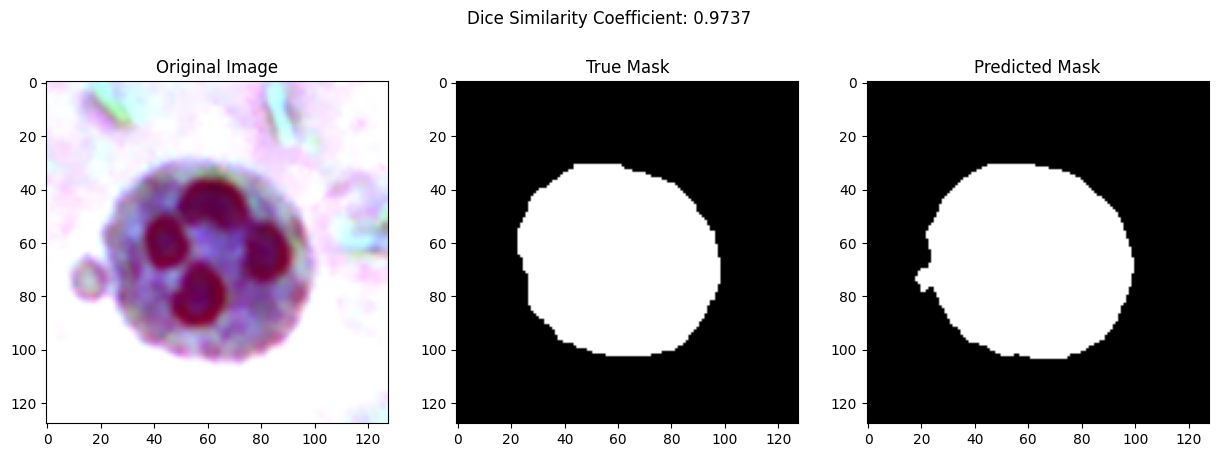

In [113]:
import numpy as np
import matplotlib.pyplot as plt

def display_prediction(model, image, true_mask, threshold=0.5):
    # Predict the mask
    pred_mask = model.predict(np.expand_dims(image, axis=0))[0]
    
    # Apply threshold to make the mask binary
    pred_mask_binary = (pred_mask >= threshold).astype(np.float32)
    true_mask_binary = (true_mask >= threshold).astype(np.float32)
    
    # Calculate the Dice coefficient using binary masks
    dsc = dice_coefficient(true_mask_binary, pred_mask_binary)

    # Plot the results
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")

    ax[1].imshow(true_mask_binary.squeeze(), cmap='gray')
    ax[1].set_title("True Mask")

    ax[2].imshow(pred_mask_binary.squeeze(), cmap='gray')
    ax[2].set_title("Predicted Mask")

    plt.suptitle(f"Dice Similarity Coefficient: {dsc:.4f}")
    plt.show()

# 
sample_index = 0  # You can change this index to visualize different samples
sample_image = val_data[sample_index]
sample_true_mask = val_masks[sample_index]
display_prediction(model, sample_image, sample_true_mask)


# Prediction Results****

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


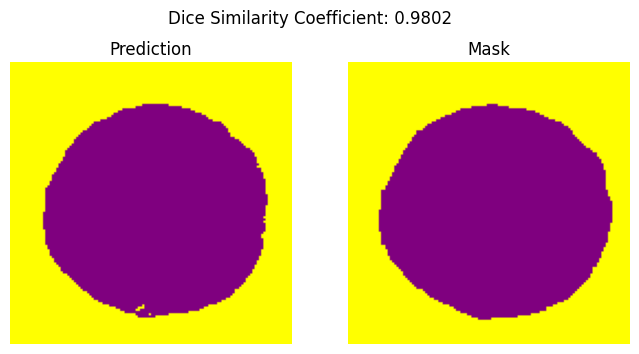

In [120]:
import numpy as np
import matplotlib.pyplot as plt

def display_prediction(model, image, true_mask):
    # Predict the mask
    pred_mask = model.predict(np.expand_dims(image, axis=0))[0]
    
    # Ensure binary masks for clean visualization
    true_mask = (true_mask > 0.5).astype(np.float32)  # Thresholding to make binary
    pred_mask = (pred_mask > 0.5).astype(np.float32)  # Thresholding to make binary

    # Calculate the Dice coefficient
    dsc = dice_coefficient(true_mask, pred_mask)

    # Prepare yellow background with purple segmented areas
    background_color = [1, 1, 0]  # RGB for yellow
    segment_color = [0.5, 0, 0.5] # RGB for purple

    def create_colored_mask(mask, bg_color, seg_color):
        color_mask = np.zeros((mask.shape[0], mask.shape[1], 3))
        color_mask[mask == 0] = bg_color  # Set background to yellow
        color_mask[mask == 1] = seg_color # Set segmented area to purple
        return color_mask

    pred_colored = create_colored_mask(pred_mask.squeeze(), background_color, segment_color)
    true_colored = create_colored_mask(true_mask.squeeze(), background_color, segment_color)

    # Plot the results
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(pred_colored)
    ax[0].set_title("Prediction")
    ax[0].axis('off')

    ax[1].imshow(true_colored)
    ax[1].set_title("Mask")
    ax[1].axis('off')

    plt.suptitle(f"Dice Similarity Coefficient: {dsc:.4f}")
    plt.show()

# Test on a sample image
sample_index = 3  # You can change this index to visualize different samples
sample_image = val_data[sample_index]
sample_true_mask = val_masks[sample_index]
display_prediction(model, sample_image, sample_true_mask)


# Prediction Results****

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


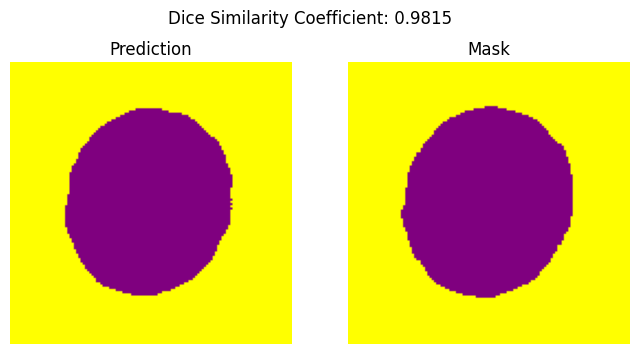

In [121]:
import numpy as np
import matplotlib.pyplot as plt

def display_prediction(model, image, true_mask):
    # Predict the mask
    pred_mask = model.predict(np.expand_dims(image, axis=0))[0]
    
    # Ensure binary masks for clean visualization
    true_mask = (true_mask > 0.5).astype(np.float32)  # Thresholding to make binary
    pred_mask = (pred_mask > 0.5).astype(np.float32)  # Thresholding to make binary

    # Calculate the Dice coefficient
    dsc = dice_coefficient(true_mask, pred_mask)

    # Prepare yellow background with purple segmented areas
    background_color = [1, 1, 0]  # RGB for yellow
    segment_color = [0.5, 0, 0.5] # RGB for purple

    def create_colored_mask(mask, bg_color, seg_color):
        color_mask = np.zeros((mask.shape[0], mask.shape[1], 3))
        color_mask[mask == 0] = bg_color  # Set background to yellow
        color_mask[mask == 1] = seg_color # Set segmented area to purple
        return color_mask

    pred_colored = create_colored_mask(pred_mask.squeeze(), background_color, segment_color)
    true_colored = create_colored_mask(true_mask.squeeze(), background_color, segment_color)

    # Plot the results
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(pred_colored)
    ax[0].set_title("Prediction")
    ax[0].axis('off')

    ax[1].imshow(true_colored)
    ax[1].set_title("Mask")
    ax[1].axis('off')

    plt.suptitle(f"Dice Similarity Coefficient: {dsc:.4f}")
    plt.show()

# Test on a sample image
sample_index =4  # You can change this index to visualize different samples
sample_image = val_data[sample_index]
sample_true_mask = val_masks[sample_index]
display_prediction(model, sample_image, sample_true_mask)


# Prediction Results****

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


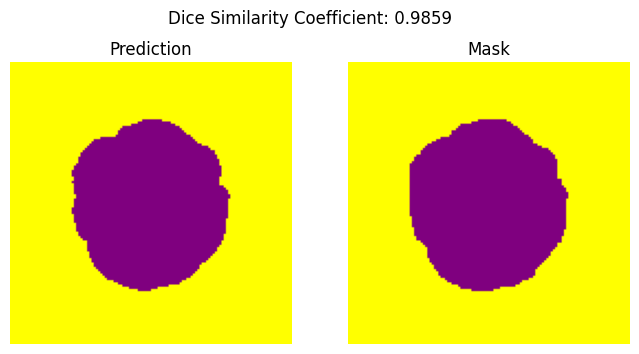

In [122]:
import numpy as np
import matplotlib.pyplot as plt

def display_prediction(model, image, true_mask):
    # Predict the mask
    pred_mask = model.predict(np.expand_dims(image, axis=0))[0]
    
    # Ensure binary masks for clean visualization
    true_mask = (true_mask > 0.5).astype(np.float32)  # Thresholding to make binary
    pred_mask = (pred_mask > 0.5).astype(np.float32)  # Thresholding to make binary

    # Calculate the Dice coefficient
    dsc = dice_coefficient(true_mask, pred_mask)

    # Prepare yellow background with purple segmented areas
    background_color = [1, 1, 0]  # RGB for yellow
    segment_color = [0.5, 0, 0.5] # RGB for purple

    def create_colored_mask(mask, bg_color, seg_color):
        color_mask = np.zeros((mask.shape[0], mask.shape[1], 3))
        color_mask[mask == 0] = bg_color  # Set background to yellow
        color_mask[mask == 1] = seg_color # Set segmented area to purple
        return color_mask

    pred_colored = create_colored_mask(pred_mask.squeeze(), background_color, segment_color)
    true_colored = create_colored_mask(true_mask.squeeze(), background_color, segment_color)

    # Plot the results
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(pred_colored)
    ax[0].set_title("Prediction")
    ax[0].axis('off')

    ax[1].imshow(true_colored)
    ax[1].set_title("Mask")
    ax[1].axis('off')

    plt.suptitle(f"Dice Similarity Coefficient: {dsc:.4f}")
    plt.show()

# Test on a sample image
sample_index = 5  # You can change this index to visualize different samples
sample_image = val_data[sample_index]
sample_true_mask = val_masks[sample_index]
display_prediction(model, sample_image, sample_true_mask)


# Prediction Results****

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


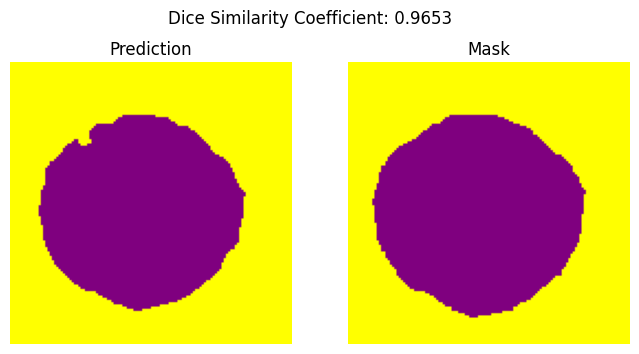

In [123]:
import numpy as np
import matplotlib.pyplot as plt

def display_prediction(model, image, true_mask):
    # Predict the mask
    pred_mask = model.predict(np.expand_dims(image, axis=0))[0]
    
    # Ensure binary masks for clean visualization
    true_mask = (true_mask > 0.5).astype(np.float32)  # Thresholding to make binary
    pred_mask = (pred_mask > 0.5).astype(np.float32)  # Thresholding to make binary

    # Calculate the Dice coefficient
    dsc = dice_coefficient(true_mask, pred_mask)

    # Prepare yellow background with purple segmented areas
    background_color = [1, 1, 0]  # RGB for yellow
    segment_color = [0.5, 0, 0.5] # RGB for purple

    def create_colored_mask(mask, bg_color, seg_color):
        color_mask = np.zeros((mask.shape[0], mask.shape[1], 3))
        color_mask[mask == 0] = bg_color  # Set background to yellow
        color_mask[mask == 1] = seg_color # Set segmented area to purple
        return color_mask

    pred_colored = create_colored_mask(pred_mask.squeeze(), background_color, segment_color)
    true_colored = create_colored_mask(true_mask.squeeze(), background_color, segment_color)

    # Plot the results
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(pred_colored)
    ax[0].set_title("Prediction")
    ax[0].axis('off')

    ax[1].imshow(true_colored)
    ax[1].set_title("Mask")
    ax[1].axis('off')

    plt.suptitle(f"Dice Similarity Coefficient: {dsc:.4f}")
    plt.show()

# Test on a sample image
sample_index = 6  # You can change this index to visualize different samples
sample_image = val_data[sample_index]
sample_true_mask = val_masks[sample_index]
display_prediction(model, sample_image, sample_true_mask)


# Prediction Results****

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


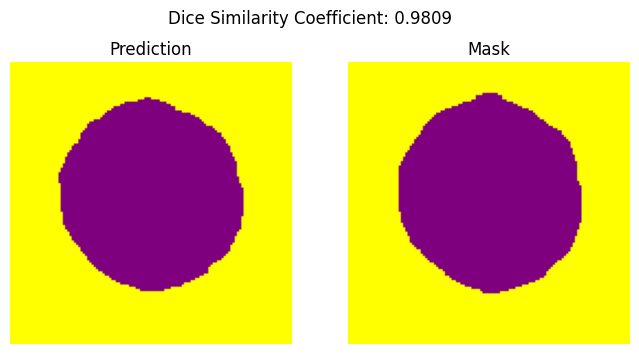

In [124]:
import numpy as np
import matplotlib.pyplot as plt

def display_prediction(model, image, true_mask):
    # Predict the mask
    pred_mask = model.predict(np.expand_dims(image, axis=0))[0]
    
    # Ensure binary masks for clean visualization
    true_mask = (true_mask > 0.5).astype(np.float32)  # Thresholding to make binary
    pred_mask = (pred_mask > 0.5).astype(np.float32)  # Thresholding to make binary

    # Calculate the Dice coefficient
    dsc = dice_coefficient(true_mask, pred_mask)

    # Prepare yellow background with purple segmented areas
    background_color = [1, 1, 0]  # RGB for yellow
    segment_color = [0.5, 0, 0.5] # RGB for purple

    def create_colored_mask(mask, bg_color, seg_color):
        color_mask = np.zeros((mask.shape[0], mask.shape[1], 3))
        color_mask[mask == 0] = bg_color  # Set background to yellow
        color_mask[mask == 1] = seg_color # Set segmented area to purple
        return color_mask

    pred_colored = create_colored_mask(pred_mask.squeeze(), background_color, segment_color)
    true_colored = create_colored_mask(true_mask.squeeze(), background_color, segment_color)

    # Plot the results
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(pred_colored)
    ax[0].set_title("Prediction")
    ax[0].axis('off')

    ax[1].imshow(true_colored)
    ax[1].set_title("Mask")
    ax[1].axis('off')

    plt.suptitle(f"Dice Similarity Coefficient: {dsc:.4f}")
    plt.show()

# Test on a sample image
sample_index = 8  # You can change this index to visualize different samples
sample_image = val_data[sample_index]
sample_true_mask = val_masks[sample_index]
display_prediction(model, sample_image, sample_true_mask)


# Prediction Results****

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


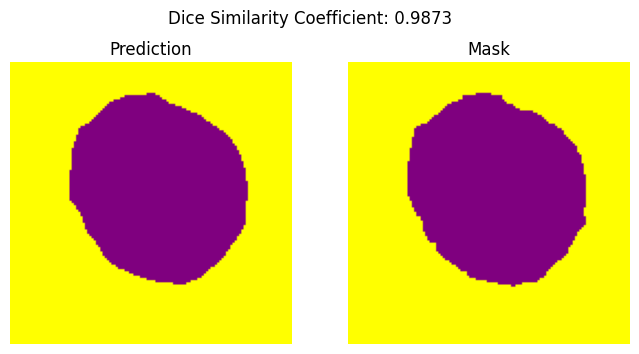

In [125]:
import numpy as np
import matplotlib.pyplot as plt

def display_prediction(model, image, true_mask):
    # Predict the mask
    pred_mask = model.predict(np.expand_dims(image, axis=0))[0]
    
    # Ensure binary masks for clean visualization
    true_mask = (true_mask > 0.5).astype(np.float32)  # Thresholding to make binary
    pred_mask = (pred_mask > 0.5).astype(np.float32)  # Thresholding to make binary

    # Calculate the Dice coefficient
    dsc = dice_coefficient(true_mask, pred_mask)

    # Prepare yellow background with purple segmented areas
    background_color = [1, 1, 0]  # RGB for yellow
    segment_color = [0.5, 0, 0.5] # RGB for purple

    def create_colored_mask(mask, bg_color, seg_color):
        color_mask = np.zeros((mask.shape[0], mask.shape[1], 3))
        color_mask[mask == 0] = bg_color  # Set background to yellow
        color_mask[mask == 1] = seg_color # Set segmented area to purple
        return color_mask

    pred_colored = create_colored_mask(pred_mask.squeeze(), background_color, segment_color)
    true_colored = create_colored_mask(true_mask.squeeze(), background_color, segment_color)

    # Plot the results
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(pred_colored)
    ax[0].set_title("Prediction")
    ax[0].axis('off')

    ax[1].imshow(true_colored)
    ax[1].set_title("Mask")
    ax[1].axis('off')

    plt.suptitle(f"Dice Similarity Coefficient: {dsc:.4f}")
    plt.show()

# Test on a sample image
sample_index = 10  # You can change this index to visualize different samples
sample_image = val_data[sample_index]
sample_true_mask = val_masks[sample_index]
display_prediction(model, sample_image, sample_true_mask)
